# 二値分類：映画レビュー

映画レビューのテキストの内容に基づいて、肯定的なレビューと否定的なレビューに分類

## IMDbデータセット

Internet Movie Database（IMDb）：  
- 訓練用の25,000件のレビューとテスト用の25,000件のレビューで構成
- 否定的なレビュー50%と肯定的なレビュー50%で構成

In [1]:
from keras.datasets import imdb

# 訓練データにおいて出現頻度の高い10,000個の単語のみ残し、IMDbロード
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Using TensorFlow backend.


In [2]:
train_data

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [3]:
max([max(seq) for seq in train_data])
# 出現頻度の高い10,000個の単語に制限しているため、単語のインデックスが10,000を超えることはない

9999

In [4]:
# IMDbのデータは整数インデックスで構成されている
# 整数インデックスを英単語に戻すにはword_indexを使う
word_index = imdb.get_word_index()
reverse_word_index = dict( # 単語マッピング
    [(value, key) for (key, value) in word_index.items()]
)
# 整数インデックスで構成されたデータを英単語に戻す関数
def decode_review(data):
    # レビューの0, 1, 2番目のインデックスは「パディング」「シーケンス開始」「不明」に予約されている
    return ' '.join([reverse_word_index.get(i-3, '?') for i in data])

print(decode_review(train_data[0])) # 訓練データ[0]のレビュー
print(train_labels[0]) # 訓練データ[0]のラベル（0＝否定的、1＝肯定的）

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

## データの準備

ニューラルネットワークに供給するためには、データをテンソル（n次元配列）に変換しなければならない

これには次の2つの方法がある

1. リストを全て同じ長さに揃え、形状が (samples, word_indicies) の整数型テンソルに変換する。さらに、ネットワークの最初の層を、そのようなテンソルを扱える層（埋め込み層）として使用する。
2. one-hotエンコーディングによりリストを0と1のベクトルに変換する。たとえばシーケンス\[3, 5\]は、3、5番目のインデックスが1である以外は全て0の10,000次元のベクトルに変換される（単語数を10,000に限定しているため）。この場合、ネットワークの最初の層は、浮動小数点数のベクトルデータを扱うことができるDense層（全結合層）として使用する。

今回は2番めの方法を採用する

In [5]:
import numpy as np

def vectorize_sequence(sequences, dimension=10000):
    res = np.zeros((len(sequences), dimension))
    for i, seq in enumerate(sequences):
        res[i, seq] = 1.
    return res

# 訓練データのベクトル化
x_train = vectorize_sequence(train_data)
# テストデータのベクトル化
x_test = vectorize_sequence(test_data)

x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [9]:
len(x_train[0])

10000

In [6]:
# ラベルもベクトル化
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

y_train[0]

1.0

## ニューラルネットワークの構築

　入力データがベクトルで、ラベルがスカラー（0と1）であるような単純な問題に適しているのは、単純な全結合層のスタックとReLU（Rectified Linear Unit）活性化関数で構成されたニューラルネットワークである

**Dense(16, activation='relu')**

　各Dense層に渡される引数(16)は、その層の隠れユニットの数である。ReLU活性化関数を持つDense層は、以下のテンソル演算の連鎖を実装する。

**output = relu(dot(W, input) + b)**

　16個の隠れユニットを持つということは、重み行列Wの形状が (input_dimension, 16) になるということ。通常、隠れユニットの数が多いほど複雑な学習が可能だが、計算量が増えるため無駄なパターンの学習が起こる可能性も増える。

　今回は、以下のようなネットワークを採用する

**input（ベクトル化されたレビュー） -> Dense(16) -> Dense(16) -> Dense(1) -> output（確率）**

　今回の問題は二値分類問題であり、出力が確率となるため、ネットワークの最後の層はシグモイド活性関数を使用する単一ユニットとする

In [17]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_dim=10000))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
# 損失関数とオプティマイザを選択
# 二値分類問題の場合、損失関数はbinary_crossentropyが最適
# オプティマイザは今回、rmspropを採用
# 指標は正解率（accuracy）を見ることとした
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# 検証データセットの設定
# 全く新しいデータセットでモデル訓練するときの正解率を監視するには、検証用のデータが必要
# 検証用に訓練データをさらに10,000個のサンプルに切り分ける
x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:]

partial_x_train.shape

(15000, 10000)

In [20]:
# モデルの訓練
# 512サンプルのミニバッチで20エポックの訓練を行う
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 5s 314us/step - loss: 0.5223 - acc: 0.7747 - val_loss: 0.3959 - val_acc: 0.8592
Epoch 2/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.3142 - acc: 0.9003 - val_loss: 0.3118 - val_acc: 0.8844
Epoch 3/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.2307 - acc: 0.9255 - val_loss: 0.3005 - val_acc: 0.8809
Epoch 4/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.1817 - acc: 0.9428 - val_loss: 0.2791 - val_acc: 0.8877
Epoch 5/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.1481 - acc: 0.9544 - val_loss: 0.2772 - val_acc: 0.8876
Epoch 6/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.1212 - acc: 0.9635 - val_loss: 0.3080 - val_acc: 0.8804
Epoch 7/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.0991 - acc: 0.9727 - val_loss: 0.3032 - val_ac

In [21]:
# 訓練中に起こったイベントの内容を確認
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

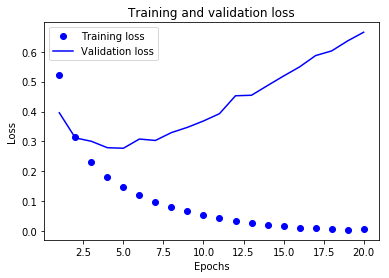

In [23]:
# 訓練データと検証データの損失値をプロット
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') # "bo"は"blue dot"（青の点線）のこと
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') # "b"は"solid blue line"（青の実線）のこと
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

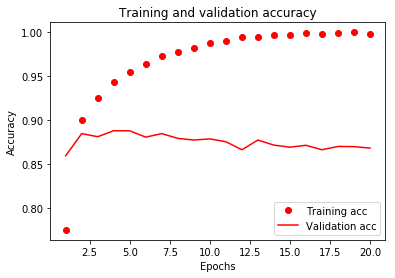

In [26]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

plt.clf() # 図を消去
plt.plot(epochs, acc_values, 'ro', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

上図を見ると、訓練データの正解率が訓練を重ねるごとに向上しているのに反して、検証データの正解率は4エポック目あたりを最高値として、徐々に下がっていっている

これは**過学習**が起きていることを意味している

そのため、今回の場合、訓練は4エポック程度が妥当であったと分かる

In [29]:
# 4エポックで再度訓練を行う
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_dim=10000))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=4, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 3s 196us/step - loss: 0.5326 - acc: 0.7917 - val_loss: 0.4064 - val_acc: 0.8700
Epoch 2/4
15000/15000 [==============================] - 2s 101us/step - loss: 0.3258 - acc: 0.8987 - val_loss: 0.3154 - val_acc: 0.8851
Epoch 3/4
15000/15000 [==============================] - 1s 100us/step - loss: 0.2357 - acc: 0.9245 - val_loss: 0.2827 - val_acc: 0.8899
Epoch 4/4
15000/15000 [==============================] - 1s 99us/step - loss: 0.1866 - acc: 0.9397 - val_loss: 0.2862 - val_acc: 0.8838


In [31]:
# 最終結果を表示
results = model.evaluate(x_test, y_test)
print(results)

25000/25000 [==============================] - 2s 85us/step
[0.3013491545677185, 0.8772]


今回のアプローチでは87%の正解率が達成できた

なお、最先端のアプローチでは95%近い正解率を達成できる

In [33]:
# 学習済みネットワークを使って予測を行う
y_pred = model.predict(x_test)
print(y_pred)

[[0.3349126 ]
 [0.9995926 ]
 [0.9345059 ]
 ...
 [0.14445111]
 [0.19112664]
 [0.6551966 ]]


In [35]:
# 平均二乗誤差（MSE）で予測値の評価を行う
from sklearn.metrics import mean_squared_error

print("正解率：", (1. - np.sqrt(mean_squared_error(y_test, y_pred))) * 100, "%")

正解率： 70.0016587972641 %


## ニューラルネットワークの検証

　今回のアプローチでは、予測値の正解率は70%程度であり、まだまだ改善の余地がある。そこで、以下のような改善案を試してみる。
 
 - 隠れ層を1つに減らす、または3つに増やす
 - 隠れユニットを8ユニットに減らす、または32ユニットに増やす
 - 損失関数をmseに変更する
 - 活性化関数をtanhに変更する

In [39]:
# 隠れ層を1つに減らして学習
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_dim=10000))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=10, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)
print("最終結果：", results)
y_pred = model.predict(x_test)
print("正解率：", (1. - np.sqrt(mean_squared_error(y_test, y_pred))) * 100, "%")

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 2s 118us/step - loss: 0.4952 - acc: 0.7935 - val_loss: 0.3780 - val_acc: 0.8730
Epoch 2/10
15000/15000 [==============================] - 2s 102us/step - loss: 0.3061 - acc: 0.9070 - val_loss: 0.3101 - val_acc: 0.8910
Epoch 3/10
15000/15000 [==============================] - 2s 100us/step - loss: 0.2358 - acc: 0.9285 - val_loss: 0.2850 - val_acc: 0.8928
Epoch 4/10
15000/15000 [==============================] - 2s 100us/step - loss: 0.1958 - acc: 0.9404 - val_loss: 0.2847 - val_acc: 0.8842
Epoch 5/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.1658 - acc: 0.9503 - val_loss: 0.2733 - val_acc: 0.8899
Epoch 6/10
15000/15000 [==============================] - 2s 100us/step - loss: 0.1437 - acc: 0.9576 - val_loss: 0.2772 - val_acc: 0.8889
Epoch 7/10
15000/15000 [==============================] - 2s 100us/step - loss: 0.1238 - acc: 0.9648 - val_loss: 0.2963 - 

In [40]:
# 隠れ層を3つに増やして学習
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_dim=10000))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=10, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)
print("最終結果：", results)
y_pred = model.predict(x_test)
print("正解率：", (1. - np.sqrt(mean_squared_error(y_test, y_pred))) * 100, "%")

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 2s 124us/step - loss: 0.5819 - acc: 0.7102 - val_loss: 0.4904 - val_acc: 0.8528
Epoch 2/10
15000/15000 [==============================] - 2s 106us/step - loss: 0.3954 - acc: 0.8925 - val_loss: 0.3717 - val_acc: 0.8629
Epoch 3/10
15000/15000 [==============================] - 2s 103us/step - loss: 0.2654 - acc: 0.9261 - val_loss: 0.3004 - val_acc: 0.8852
Epoch 4/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.1907 - acc: 0.9438 - val_loss: 0.3068 - val_acc: 0.8807
Epoch 5/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.1480 - acc: 0.9549 - val_loss: 0.3012 - val_acc: 0.8830
Epoch 6/10
15000/15000 [==============================] - 2s 102us/step - loss: 0.1187 - acc: 0.9641 - val_loss: 0.3233 - val_acc: 0.8788
Epoch 7/10
15000/15000 [==============================] - 2s 100us/step - loss: 0.0960 - acc: 0.9737 - val_loss: 0.3733 - 

In [41]:
# 隠れユニットを8ユニットに減らして学習
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_dim=10000))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=10, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)
print("最終結果：", results)
y_pred = model.predict(x_test)
print("正解率：", (1. - np.sqrt(mean_squared_error(y_test, y_pred))) * 100, "%")

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 2s 124us/step - loss: 0.5670 - acc: 0.7787 - val_loss: 0.4763 - val_acc: 0.8260
Epoch 2/10
15000/15000 [==============================] - 1s 100us/step - loss: 0.3970 - acc: 0.8865 - val_loss: 0.3806 - val_acc: 0.8643
Epoch 3/10
15000/15000 [==============================] - 2s 102us/step - loss: 0.3055 - acc: 0.9112 - val_loss: 0.3221 - val_acc: 0.8866
Epoch 4/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.2454 - acc: 0.9282 - val_loss: 0.3015 - val_acc: 0.8850
Epoch 5/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.2040 - acc: 0.9385 - val_loss: 0.2834 - val_acc: 0.8886
Epoch 6/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.1726 - acc: 0.9493 - val_loss: 0.2829 - val_acc: 0.8878
Epoch 7/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.1486 - acc: 0.9557 - val_loss: 0.2755 - 

In [42]:
# 隠れユニットを32ユニットに増やして学習
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_dim=10000))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=10, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)
print("最終結果：", results)
y_pred = model.predict(x_test)
print("正解率：", (1. - np.sqrt(mean_squared_error(y_test, y_pred))) * 100, "%")

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 2s 127us/step - loss: 0.4863 - acc: 0.7777 - val_loss: 0.3344 - val_acc: 0.8817
Epoch 2/10
15000/15000 [==============================] - 2s 102us/step - loss: 0.2683 - acc: 0.9049 - val_loss: 0.2905 - val_acc: 0.8842
Epoch 3/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.1986 - acc: 0.9284 - val_loss: 0.2871 - val_acc: 0.8855
Epoch 4/10
15000/15000 [==============================] - 2s 102us/step - loss: 0.1565 - acc: 0.9469 - val_loss: 0.2900 - val_acc: 0.8860
Epoch 5/10
15000/15000 [==============================] - 2s 103us/step - loss: 0.1187 - acc: 0.9594 - val_loss: 0.3055 - val_acc: 0.8831
Epoch 6/10
15000/15000 [==============================] - 2s 104us/step - loss: 0.1020 - acc: 0.9656 - val_loss: 0.3316 - val_acc: 0.8822
Epoch 7/10
15000/15000 [==============================] - 2s 103us/step - loss: 0.0793 - acc: 0.9749 - val_loss: 0.3537 - 

In [43]:
# 損失関数をmseに変更して学習
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_dim=10000))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=10, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)
print("最終結果：", results)
y_pred = model.predict(x_test)
print("正解率：", (1. - np.sqrt(mean_squared_error(y_test, y_pred))) * 100, "%")

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 2s 123us/step - loss: 0.1760 - acc: 0.7816 - val_loss: 0.1255 - val_acc: 0.8638
Epoch 2/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.0962 - acc: 0.9026 - val_loss: 0.0962 - val_acc: 0.8865
Epoch 3/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.0679 - acc: 0.9298 - val_loss: 0.0869 - val_acc: 0.8893
Epoch 4/10
15000/15000 [==============================] - 2s 100us/step - loss: 0.0520 - acc: 0.9460 - val_loss: 0.0839 - val_acc: 0.8879
Epoch 5/10
15000/15000 [==============================] - 2s 104us/step - loss: 0.0421 - acc: 0.9574 - val_loss: 0.0828 - val_acc: 0.8880
Epoch 6/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.0337 - acc: 0.9683 - val_loss: 0.0869 - val_acc: 0.8796
Epoch 7/10
15000/15000 [==============================] - 2s 100us/step - loss: 0.0280 - acc: 0.9735 - val_loss: 0.0858 - 

In [44]:
# 活性化関数をtanhに変更して学習
model = models.Sequential()
model.add(layers.Dense(16, activation='tanh', input_dim=10000))
model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=10, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)
print("最終結果：", results)
y_pred = model.predict(x_test)
print("正解率：", (1. - np.sqrt(mean_squared_error(y_test, y_pred))) * 100, "%")

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 2s 127us/step - loss: 0.4662 - acc: 0.8017 - val_loss: 0.3434 - val_acc: 0.8741
Epoch 2/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.2570 - acc: 0.9127 - val_loss: 0.2895 - val_acc: 0.8830
Epoch 3/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.1891 - acc: 0.9341 - val_loss: 0.2798 - val_acc: 0.8848
Epoch 4/10
15000/15000 [==============================] - 2s 102us/step - loss: 0.1424 - acc: 0.9523 - val_loss: 0.2899 - val_acc: 0.8863
Epoch 5/10
15000/15000 [==============================] - 2s 102us/step - loss: 0.1048 - acc: 0.9657 - val_loss: 0.3165 - val_acc: 0.8804
Epoch 6/10
15000/15000 [==============================] - 2s 100us/step - loss: 0.0913 - acc: 0.9690 - val_loss: 0.3642 - val_acc: 0.8739
Epoch 7/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.0643 - acc: 0.9805 - val_loss: 0.3925 - 

In [45]:
# オプティマイザをadamに変更して学習
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_dim=10000))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=10, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)
print("最終結果：", results)
y_pred = model.predict(x_test)
print("正解率：", (1. - np.sqrt(mean_squared_error(y_test, y_pred))) * 100, "%")

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 2s 137us/step - loss: 0.5714 - acc: 0.7581 - val_loss: 0.4168 - val_acc: 0.8524
Epoch 2/10
15000/15000 [==============================] - 2s 102us/step - loss: 0.3108 - acc: 0.8978 - val_loss: 0.2983 - val_acc: 0.8878
Epoch 3/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.2086 - acc: 0.9304 - val_loss: 0.2769 - val_acc: 0.8894
Epoch 4/10
15000/15000 [==============================] - 2s 102us/step - loss: 0.1516 - acc: 0.9537 - val_loss: 0.2846 - val_acc: 0.8853
Epoch 5/10
15000/15000 [==============================] - 2s 104us/step - loss: 0.1148 - acc: 0.9678 - val_loss: 0.2958 - val_acc: 0.8819
Epoch 6/10
15000/15000 [==============================] - 2s 102us/step - loss: 0.0870 - acc: 0.9789 - val_loss: 0.3214 - val_acc: 0.8799
Epoch 7/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.0664 - acc: 0.9865 - val_loss: 0.3475 - 

In [46]:
# テスト：簡単なネットワークで1000エポック学習
model = models.Sequential()
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=1000, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)
print("最終結果：", results)
y_pred = model.predict(x_test)
print("正解率：", (1. - np.sqrt(mean_squared_error(y_test, y_pred))) * 100, "%")

Train on 15000 samples, validate on 10000 samples
Epoch 1/1000
15000/15000 [==============================] - 2s 132us/step - loss: 0.6132 - acc: 0.7462 - val_loss: 0.5594 - val_acc: 0.8168
Epoch 2/1000
15000/15000 [==============================] - 2s 100us/step - loss: 0.5154 - acc: 0.8431 - val_loss: 0.4961 - val_acc: 0.8406
Epoch 3/1000
15000/15000 [==============================] - 2s 101us/step - loss: 0.4544 - acc: 0.8669 - val_loss: 0.4510 - val_acc: 0.8558
Epoch 4/1000
15000/15000 [==============================] - 2s 101us/step - loss: 0.4087 - acc: 0.8817 - val_loss: 0.4176 - val_acc: 0.8625
Epoch 5/1000
15000/15000 [==============================] - 1s 99us/step - loss: 0.3735 - acc: 0.8937 - val_loss: 0.3919 - val_acc: 0.8675
Epoch 6/1000
15000/15000 [==============================] - 2s 102us/step - loss: 0.3454 - acc: 0.8997 - val_loss: 0.3718 - val_acc: 0.8737
Epoch 7/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.3221 - acc: 0.9071 - val_lo

Epoch 59/1000
15000/15000 [==============================] - 2s 101us/step - loss: 0.0920 - acc: 0.9802 - val_loss: 0.2914 - val_acc: 0.8851
Epoch 60/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0908 - acc: 0.9812 - val_loss: 0.2925 - val_acc: 0.8856
Epoch 61/1000
15000/15000 [==============================] - 2s 100us/step - loss: 0.0894 - acc: 0.9815 - val_loss: 0.2934 - val_acc: 0.8853
Epoch 62/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0882 - acc: 0.9819 - val_loss: 0.2949 - val_acc: 0.8854
Epoch 63/1000
15000/15000 [==============================] - 1s 99us/step - loss: 0.0870 - acc: 0.9821 - val_loss: 0.2958 - val_acc: 0.8847
Epoch 64/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0858 - acc: 0.9823 - val_loss: 0.2965 - val_acc: 0.8846
Epoch 65/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0845 - acc: 0.9827 - val_loss: 0.2977 - val_acc: 0.8848
Epoch 66/1000


15000/15000 [==============================] - 1s 100us/step - loss: 0.0450 - acc: 0.9946 - val_loss: 0.3597 - val_acc: 0.8772
Epoch 118/1000
15000/15000 [==============================] - 1s 99us/step - loss: 0.0445 - acc: 0.9949 - val_loss: 0.3609 - val_acc: 0.8772
Epoch 119/1000
15000/15000 [==============================] - 2s 100us/step - loss: 0.0440 - acc: 0.9948 - val_loss: 0.3621 - val_acc: 0.8773
Epoch 120/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0435 - acc: 0.9949 - val_loss: 0.3635 - val_acc: 0.8769
Epoch 121/1000
15000/15000 [==============================] - 2s 101us/step - loss: 0.0430 - acc: 0.9952 - val_loss: 0.3648 - val_acc: 0.8767
Epoch 122/1000
15000/15000 [==============================] - 2s 102us/step - loss: 0.0426 - acc: 0.9950 - val_loss: 0.3666 - val_acc: 0.8777
Epoch 123/1000
15000/15000 [==============================] - 2s 101us/step - loss: 0.0421 - acc: 0.9951 - val_loss: 0.3673 - val_acc: 0.8769
Epoch 124/1000
15000/1

Epoch 175/1000
15000/15000 [==============================] - 1s 98us/step - loss: 0.0244 - acc: 0.9985 - val_loss: 0.4361 - val_acc: 0.8688
Epoch 176/1000
15000/15000 [==============================] - 2s 102us/step - loss: 0.0241 - acc: 0.9985 - val_loss: 0.4375 - val_acc: 0.8687
Epoch 177/1000
15000/15000 [==============================] - 2s 103us/step - loss: 0.0238 - acc: 0.9984 - val_loss: 0.4388 - val_acc: 0.8688
Epoch 178/1000
15000/15000 [==============================] - 2s 102us/step - loss: 0.0236 - acc: 0.9985 - val_loss: 0.4402 - val_acc: 0.8692
Epoch 179/1000
15000/15000 [==============================] - 2s 101us/step - loss: 0.0234 - acc: 0.9985 - val_loss: 0.4416 - val_acc: 0.8685
Epoch 180/1000
15000/15000 [==============================] - 2s 102us/step - loss: 0.0231 - acc: 0.9985 - val_loss: 0.4429 - val_acc: 0.8680
Epoch 181/1000
15000/15000 [==============================] - 2s 104us/step - loss: 0.0229 - acc: 0.9985 - val_loss: 0.4444 - val_acc: 0.8680
Epoch 1

Epoch 233/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0136 - acc: 0.9997 - val_loss: 0.5138 - val_acc: 0.8658
Epoch 234/1000
15000/15000 [==============================] - 2s 101us/step - loss: 0.0135 - acc: 0.9997 - val_loss: 0.5152 - val_acc: 0.8654
Epoch 235/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0134 - acc: 0.9997 - val_loss: 0.5164 - val_acc: 0.8656
Epoch 236/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0132 - acc: 0.9997 - val_loss: 0.5180 - val_acc: 0.8655
Epoch 237/1000
15000/15000 [==============================] - 1s 99us/step - loss: 0.0131 - acc: 0.9997 - val_loss: 0.5192 - val_acc: 0.8657
Epoch 238/1000
15000/15000 [==============================] - 2s 101us/step - loss: 0.0130 - acc: 0.9997 - val_loss: 0.5205 - val_acc: 0.8652
Epoch 239/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0128 - acc: 0.9997 - val_loss: 0.5218 - val_acc: 0.8650
Epoch 2

Epoch 291/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0077 - acc: 0.9999 - val_loss: 0.5909 - val_acc: 0.8631
Epoch 292/1000
15000/15000 [==============================] - 2s 101us/step - loss: 0.0077 - acc: 0.9999 - val_loss: 0.5924 - val_acc: 0.8621
Epoch 293/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0076 - acc: 0.9999 - val_loss: 0.5935 - val_acc: 0.8630
Epoch 294/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0075 - acc: 0.9999 - val_loss: 0.5949 - val_acc: 0.8625
Epoch 295/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0074 - acc: 0.9999 - val_loss: 0.5963 - val_acc: 0.8623
Epoch 296/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0074 - acc: 0.9999 - val_loss: 0.5975 - val_acc: 0.8625
Epoch 297/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0073 - acc: 0.9999 - val_loss: 0.5989 - val_acc: 0.8624
Epoch 

Epoch 349/1000
15000/15000 [==============================] - 1s 99us/step - loss: 0.0044 - acc: 0.9999 - val_loss: 0.6683 - val_acc: 0.8594
Epoch 350/1000
15000/15000 [==============================] - 2s 102us/step - loss: 0.0044 - acc: 0.9999 - val_loss: 0.6696 - val_acc: 0.8594
Epoch 351/1000
15000/15000 [==============================] - 2s 101us/step - loss: 0.0044 - acc: 0.9999 - val_loss: 0.6710 - val_acc: 0.8595
Epoch 352/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0043 - acc: 0.9999 - val_loss: 0.6722 - val_acc: 0.8593
Epoch 353/1000
15000/15000 [==============================] - 2s 100us/step - loss: 0.0043 - acc: 0.9999 - val_loss: 0.6737 - val_acc: 0.8595
Epoch 354/1000
15000/15000 [==============================] - 2s 102us/step - loss: 0.0042 - acc: 0.9999 - val_loss: 0.6749 - val_acc: 0.8592
Epoch 355/1000
15000/15000 [==============================] - 2s 100us/step - loss: 0.0042 - acc: 0.9999 - val_loss: 0.6763 - val_acc: 0.8591
Epoch 3

Epoch 407/1000
15000/15000 [==============================] - 2s 100us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.7435 - val_acc: 0.8581
Epoch 408/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.7448 - val_acc: 0.8579
Epoch 409/1000
15000/15000 [==============================] - 2s 100us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.7461 - val_acc: 0.8577
Epoch 410/1000
15000/15000 [==============================] - 1s 99us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.7474 - val_acc: 0.8577
Epoch 411/1000
15000/15000 [==============================] - 1s 100us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.7486 - val_acc: 0.8576
Epoch 412/1000
15000/15000 [==============================] - 1s 99us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.7502 - val_acc: 0.8575
Epoch 413/1000
15000/15000 [==============================] - 1s 99us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.7512 - val_acc: 0.8575
Epoch 414

Epoch 465/1000
15000/15000 [==============================] - 2s 102us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.8159 - val_acc: 0.8563
Epoch 466/1000
15000/15000 [==============================] - 2s 101us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.8171 - val_acc: 0.8565
Epoch 467/1000
15000/15000 [==============================] - 2s 100us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.8182 - val_acc: 0.8563
Epoch 468/1000
15000/15000 [==============================] - 1s 99us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.8195 - val_acc: 0.8562
Epoch 469/1000
15000/15000 [==============================] - 2s 101us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.8209 - val_acc: 0.8562
Epoch 470/1000
15000/15000 [==============================] - 2s 101us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.8221 - val_acc: 0.8563
Epoch 471/1000
15000/15000 [==============================] - 2s 102us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.8232 - val_acc: 0.8562
Epoch 4

15000/15000 [==============================] - 2s 102us/step - loss: 8.9770e-04 - acc: 1.0000 - val_loss: 0.8840 - val_acc: 0.8553
Epoch 523/1000
15000/15000 [==============================] - 2s 100us/step - loss: 8.8809e-04 - acc: 1.0000 - val_loss: 0.8852 - val_acc: 0.8552
Epoch 524/1000
15000/15000 [==============================] - 2s 101us/step - loss: 8.8094e-04 - acc: 1.0000 - val_loss: 0.8863 - val_acc: 0.8552
Epoch 525/1000
15000/15000 [==============================] - 2s 101us/step - loss: 8.7244e-04 - acc: 1.0000 - val_loss: 0.8877 - val_acc: 0.8556
Epoch 526/1000
15000/15000 [==============================] - 1s 100us/step - loss: 8.6417e-04 - acc: 1.0000 - val_loss: 0.8888 - val_acc: 0.8554
Epoch 527/1000
15000/15000 [==============================] - 2s 101us/step - loss: 8.5690e-04 - acc: 1.0000 - val_loss: 0.8898 - val_acc: 0.8551
Epoch 528/1000
15000/15000 [==============================] - 2s 101us/step - loss: 8.4911e-04 - acc: 1.0000 - val_loss: 0.8912 - val_acc: 

15000/15000 [==============================] - 2s 101us/step - loss: 5.4308e-04 - acc: 1.0000 - val_loss: 0.9473 - val_acc: 0.8539
Epoch 579/1000
15000/15000 [==============================] - 2s 100us/step - loss: 5.3734e-04 - acc: 1.0000 - val_loss: 0.9484 - val_acc: 0.8537
Epoch 580/1000
15000/15000 [==============================] - 2s 103us/step - loss: 5.3335e-04 - acc: 1.0000 - val_loss: 0.9494 - val_acc: 0.8536
Epoch 581/1000
15000/15000 [==============================] - 2s 100us/step - loss: 5.2883e-04 - acc: 1.0000 - val_loss: 0.9504 - val_acc: 0.8536
Epoch 582/1000
15000/15000 [==============================] - 2s 101us/step - loss: 5.2432e-04 - acc: 1.0000 - val_loss: 0.9517 - val_acc: 0.8538
Epoch 583/1000
15000/15000 [==============================] - 2s 101us/step - loss: 5.1880e-04 - acc: 1.0000 - val_loss: 0.9526 - val_acc: 0.8535
Epoch 584/1000
15000/15000 [==============================] - 2s 103us/step - loss: 5.1512e-04 - acc: 1.0000 - val_loss: 0.9539 - val_acc: 

15000/15000 [==============================] - 2s 102us/step - loss: 3.3271e-04 - acc: 1.0000 - val_loss: 1.0062 - val_acc: 0.8523
Epoch 635/1000
15000/15000 [==============================] - 2s 101us/step - loss: 3.2967e-04 - acc: 1.0000 - val_loss: 1.0071 - val_acc: 0.8531
Epoch 636/1000
15000/15000 [==============================] - 2s 101us/step - loss: 3.2680e-04 - acc: 1.0000 - val_loss: 1.0080 - val_acc: 0.8531
Epoch 637/1000
15000/15000 [==============================] - 2s 101us/step - loss: 3.2386e-04 - acc: 1.0000 - val_loss: 1.0088 - val_acc: 0.8531
Epoch 638/1000
15000/15000 [==============================] - 2s 101us/step - loss: 3.2144e-04 - acc: 1.0000 - val_loss: 1.0099 - val_acc: 0.8527
Epoch 639/1000
15000/15000 [==============================] - 2s 100us/step - loss: 3.1875e-04 - acc: 1.0000 - val_loss: 1.0110 - val_acc: 0.8529
Epoch 640/1000
15000/15000 [==============================] - 2s 100us/step - loss: 3.1557e-04 - acc: 1.0000 - val_loss: 1.0125 - val_acc: 

15000/15000 [==============================] - 1s 100us/step - loss: 2.0712e-04 - acc: 1.0000 - val_loss: 1.0590 - val_acc: 0.8513
Epoch 691/1000
15000/15000 [==============================] - 2s 103us/step - loss: 2.0547e-04 - acc: 1.0000 - val_loss: 1.0599 - val_acc: 0.8515
Epoch 692/1000
15000/15000 [==============================] - 2s 101us/step - loss: 2.0382e-04 - acc: 1.0000 - val_loss: 1.0604 - val_acc: 0.8518
Epoch 693/1000
15000/15000 [==============================] - 1s 100us/step - loss: 2.0201e-04 - acc: 1.0000 - val_loss: 1.0615 - val_acc: 0.8514
Epoch 694/1000
15000/15000 [==============================] - 2s 102us/step - loss: 2.0026e-04 - acc: 1.0000 - val_loss: 1.0625 - val_acc: 0.8514
Epoch 695/1000
15000/15000 [==============================] - 2s 101us/step - loss: 1.9880e-04 - acc: 1.0000 - val_loss: 1.0632 - val_acc: 0.8513
Epoch 696/1000
15000/15000 [==============================] - 2s 101us/step - loss: 1.9719e-04 - acc: 1.0000 - val_loss: 1.0649 - val_acc: 

15000/15000 [==============================] - 2s 100us/step - loss: 1.3174e-04 - acc: 1.0000 - val_loss: 1.1065 - val_acc: 0.8509
Epoch 747/1000
15000/15000 [==============================] - 1s 100us/step - loss: 1.3081e-04 - acc: 1.0000 - val_loss: 1.1073 - val_acc: 0.8510
Epoch 748/1000
15000/15000 [==============================] - 2s 101us/step - loss: 1.2972e-04 - acc: 1.0000 - val_loss: 1.1079 - val_acc: 0.8510
Epoch 749/1000
15000/15000 [==============================] - 2s 100us/step - loss: 1.2870e-04 - acc: 1.0000 - val_loss: 1.1092 - val_acc: 0.8508
Epoch 750/1000
15000/15000 [==============================] - 1s 99us/step - loss: 1.2754e-04 - acc: 1.0000 - val_loss: 1.1092 - val_acc: 0.8507
Epoch 751/1000
15000/15000 [==============================] - 2s 101us/step - loss: 1.2688e-04 - acc: 1.0000 - val_loss: 1.1105 - val_acc: 0.8510
Epoch 752/1000
15000/15000 [==============================] - 2s 101us/step - loss: 1.2574e-04 - acc: 1.0000 - val_loss: 1.1112 - val_acc: 0

15000/15000 [==============================] - 1s 100us/step - loss: 8.6050e-05 - acc: 1.0000 - val_loss: 1.1498 - val_acc: 0.8503
Epoch 803/1000
15000/15000 [==============================] - 2s 101us/step - loss: 8.5354e-05 - acc: 1.0000 - val_loss: 1.1499 - val_acc: 0.8503
Epoch 804/1000
15000/15000 [==============================] - 1s 99us/step - loss: 8.4735e-05 - acc: 1.0000 - val_loss: 1.1507 - val_acc: 0.8503
Epoch 805/1000
15000/15000 [==============================] - 2s 103us/step - loss: 8.4088e-05 - acc: 1.0000 - val_loss: 1.1521 - val_acc: 0.8499
Epoch 806/1000
15000/15000 [==============================] - 2s 102us/step - loss: 8.3573e-05 - acc: 1.0000 - val_loss: 1.1524 - val_acc: 0.8504
Epoch 807/1000
15000/15000 [==============================] - 2s 101us/step - loss: 8.2897e-05 - acc: 1.0000 - val_loss: 1.1530 - val_acc: 0.8504
Epoch 808/1000
15000/15000 [==============================] - 1s 99us/step - loss: 8.2298e-05 - acc: 1.0000 - val_loss: 1.1535 - val_acc: 0.

15000/15000 [==============================] - 2s 100us/step - loss: 5.7886e-05 - acc: 1.0000 - val_loss: 1.1877 - val_acc: 0.8489
Epoch 859/1000
15000/15000 [==============================] - 2s 101us/step - loss: 5.7468e-05 - acc: 1.0000 - val_loss: 1.1884 - val_acc: 0.8491
Epoch 860/1000
15000/15000 [==============================] - 2s 100us/step - loss: 5.7024e-05 - acc: 1.0000 - val_loss: 1.1892 - val_acc: 0.8487
Epoch 861/1000
15000/15000 [==============================] - 1s 100us/step - loss: 5.6694e-05 - acc: 1.0000 - val_loss: 1.1893 - val_acc: 0.8489
Epoch 862/1000
15000/15000 [==============================] - 1s 100us/step - loss: 5.6351e-05 - acc: 1.0000 - val_loss: 1.1897 - val_acc: 0.8486
Epoch 863/1000
15000/15000 [==============================] - 2s 100us/step - loss: 5.5953e-05 - acc: 1.0000 - val_loss: 1.1906 - val_acc: 0.8488
Epoch 864/1000
15000/15000 [==============================] - 2s 101us/step - loss: 5.5500e-05 - acc: 1.0000 - val_loss: 1.1916 - val_acc: 

15000/15000 [==============================] - 2s 105us/step - loss: 4.0309e-05 - acc: 1.0000 - val_loss: 1.2202 - val_acc: 0.8477
Epoch 915/1000
15000/15000 [==============================] - 2s 101us/step - loss: 4.0013e-05 - acc: 1.0000 - val_loss: 1.2207 - val_acc: 0.8478
Epoch 916/1000
15000/15000 [==============================] - 2s 100us/step - loss: 3.9773e-05 - acc: 1.0000 - val_loss: 1.2213 - val_acc: 0.8476
Epoch 917/1000
15000/15000 [==============================] - 1s 100us/step - loss: 3.9563e-05 - acc: 1.0000 - val_loss: 1.2221 - val_acc: 0.8477
Epoch 918/1000
15000/15000 [==============================] - 2s 103us/step - loss: 3.9326e-05 - acc: 1.0000 - val_loss: 1.2226 - val_acc: 0.8477
Epoch 919/1000
15000/15000 [==============================] - 2s 101us/step - loss: 3.9051e-05 - acc: 1.0000 - val_loss: 1.2233 - val_acc: 0.8476
Epoch 920/1000
15000/15000 [==============================] - 2s 102us/step - loss: 3.8850e-05 - acc: 1.0000 - val_loss: 1.2235 - val_acc: 

15000/15000 [==============================] - 2s 103us/step - loss: 2.9051e-05 - acc: 1.0000 - val_loss: 1.2490 - val_acc: 0.8480
Epoch 971/1000
15000/15000 [==============================] - 1s 100us/step - loss: 2.8873e-05 - acc: 1.0000 - val_loss: 1.2493 - val_acc: 0.8479
Epoch 972/1000
15000/15000 [==============================] - 1s 99us/step - loss: 2.8703e-05 - acc: 1.0000 - val_loss: 1.2492 - val_acc: 0.8484
Epoch 973/1000
15000/15000 [==============================] - 1s 100us/step - loss: 2.8578e-05 - acc: 1.0000 - val_loss: 1.2500 - val_acc: 0.8479
Epoch 974/1000
15000/15000 [==============================] - 2s 101us/step - loss: 2.8397e-05 - acc: 1.0000 - val_loss: 1.2511 - val_acc: 0.8482
Epoch 975/1000
15000/15000 [==============================] - 1s 99us/step - loss: 2.8240e-05 - acc: 1.0000 - val_loss: 1.2509 - val_acc: 0.8480
Epoch 976/1000
15000/15000 [==============================] - 1s 100us/step - loss: 2.8103e-05 - acc: 1.0000 - val_loss: 1.2514 - val_acc: 0.

In [47]:
# テスト：簡単なネットワークで4エポック学習
model = models.Sequential()
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=4, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)
print("最終結果：", results)
y_pred = model.predict(x_test)
print("正解率：", (1. - np.sqrt(mean_squared_error(y_test, y_pred))) * 100, "%")

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 2s 134us/step - loss: 0.6116 - acc: 0.7454 - val_loss: 0.5600 - val_acc: 0.8127
Epoch 2/4
15000/15000 [==============================] - 1s 100us/step - loss: 0.5145 - acc: 0.8449 - val_loss: 0.4972 - val_acc: 0.8372
Epoch 3/4
15000/15000 [==============================] - 2s 101us/step - loss: 0.4538 - acc: 0.8660 - val_loss: 0.4523 - val_acc: 0.8520
Epoch 4/4
25000/25000 [==============================] - 2s 87us/step
最終結果： [0.4288048528003693, 0.85724]
正解率： 63.6765718460083 %
